In [395]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import math
from IPython.core.display_functions import clear_output
from tqdm import trange

In [426]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps:0")
else:
    device = torch.device("cpu")


weather = pd.read_csv('weather.csv')
weather.drop(['date', 'Tpot (K)', 'Tdew (degC)', 'Tlog (degC)'], axis=1, inplace=True)
weather_tensor = torch.tensor(weather.values.astype("float32"))
X = torch.concat([weather_tensor[:, :1], weather_tensor[:, 2:]], dim=-1).to(device)
Y = weather_tensor[:, 1:2].to(device)
X_train = X[:int(0.7*len(X))]
Y_train = Y[:int(0.7*len(Y))]
X_test = X[int(0.7*len(X)):]
Y_test = Y[int(0.7*len(Y)):]
embedding_dim = X.shape[1]



In [427]:
def plot(plot_dict, size_per_plot=5, same_plot=False):
    rows, remainder = len(plot_dict) // 4 + 1, len(plot_dict) % 4
    max_cols = 4
    cols = remainder if rows == 1 else max_cols
    width = remainder * size_per_plot if rows == 1 else max_cols * size_per_plot
    height = rows * size_per_plot
    if not same_plot:
        fig = plt.figure(figsize=(width, height))
    else:
        fig = plt.figure(figsize=(size_per_plot * 2, size_per_plot))
    for i, (plot_title, plot) in enumerate(plot_dict.items()):
        if not same_plot:
            ax = fig.add_subplot(rows, cols, i+1)
            ax.plot(plot, label=plot_title)
            ax.legend()
        else:
            plt.plot(plot, label=plot_title)
            plt.legend()
    
    plt.show()

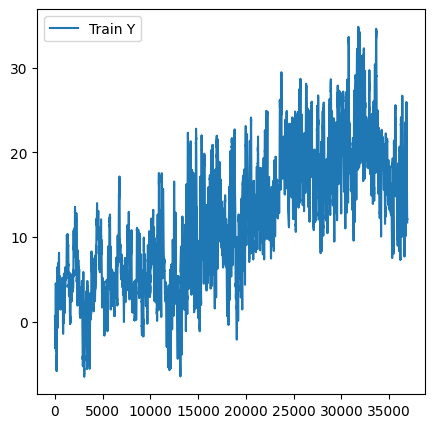

In [428]:
plot({"Train Y": Y_train.detach().cpu().numpy()})

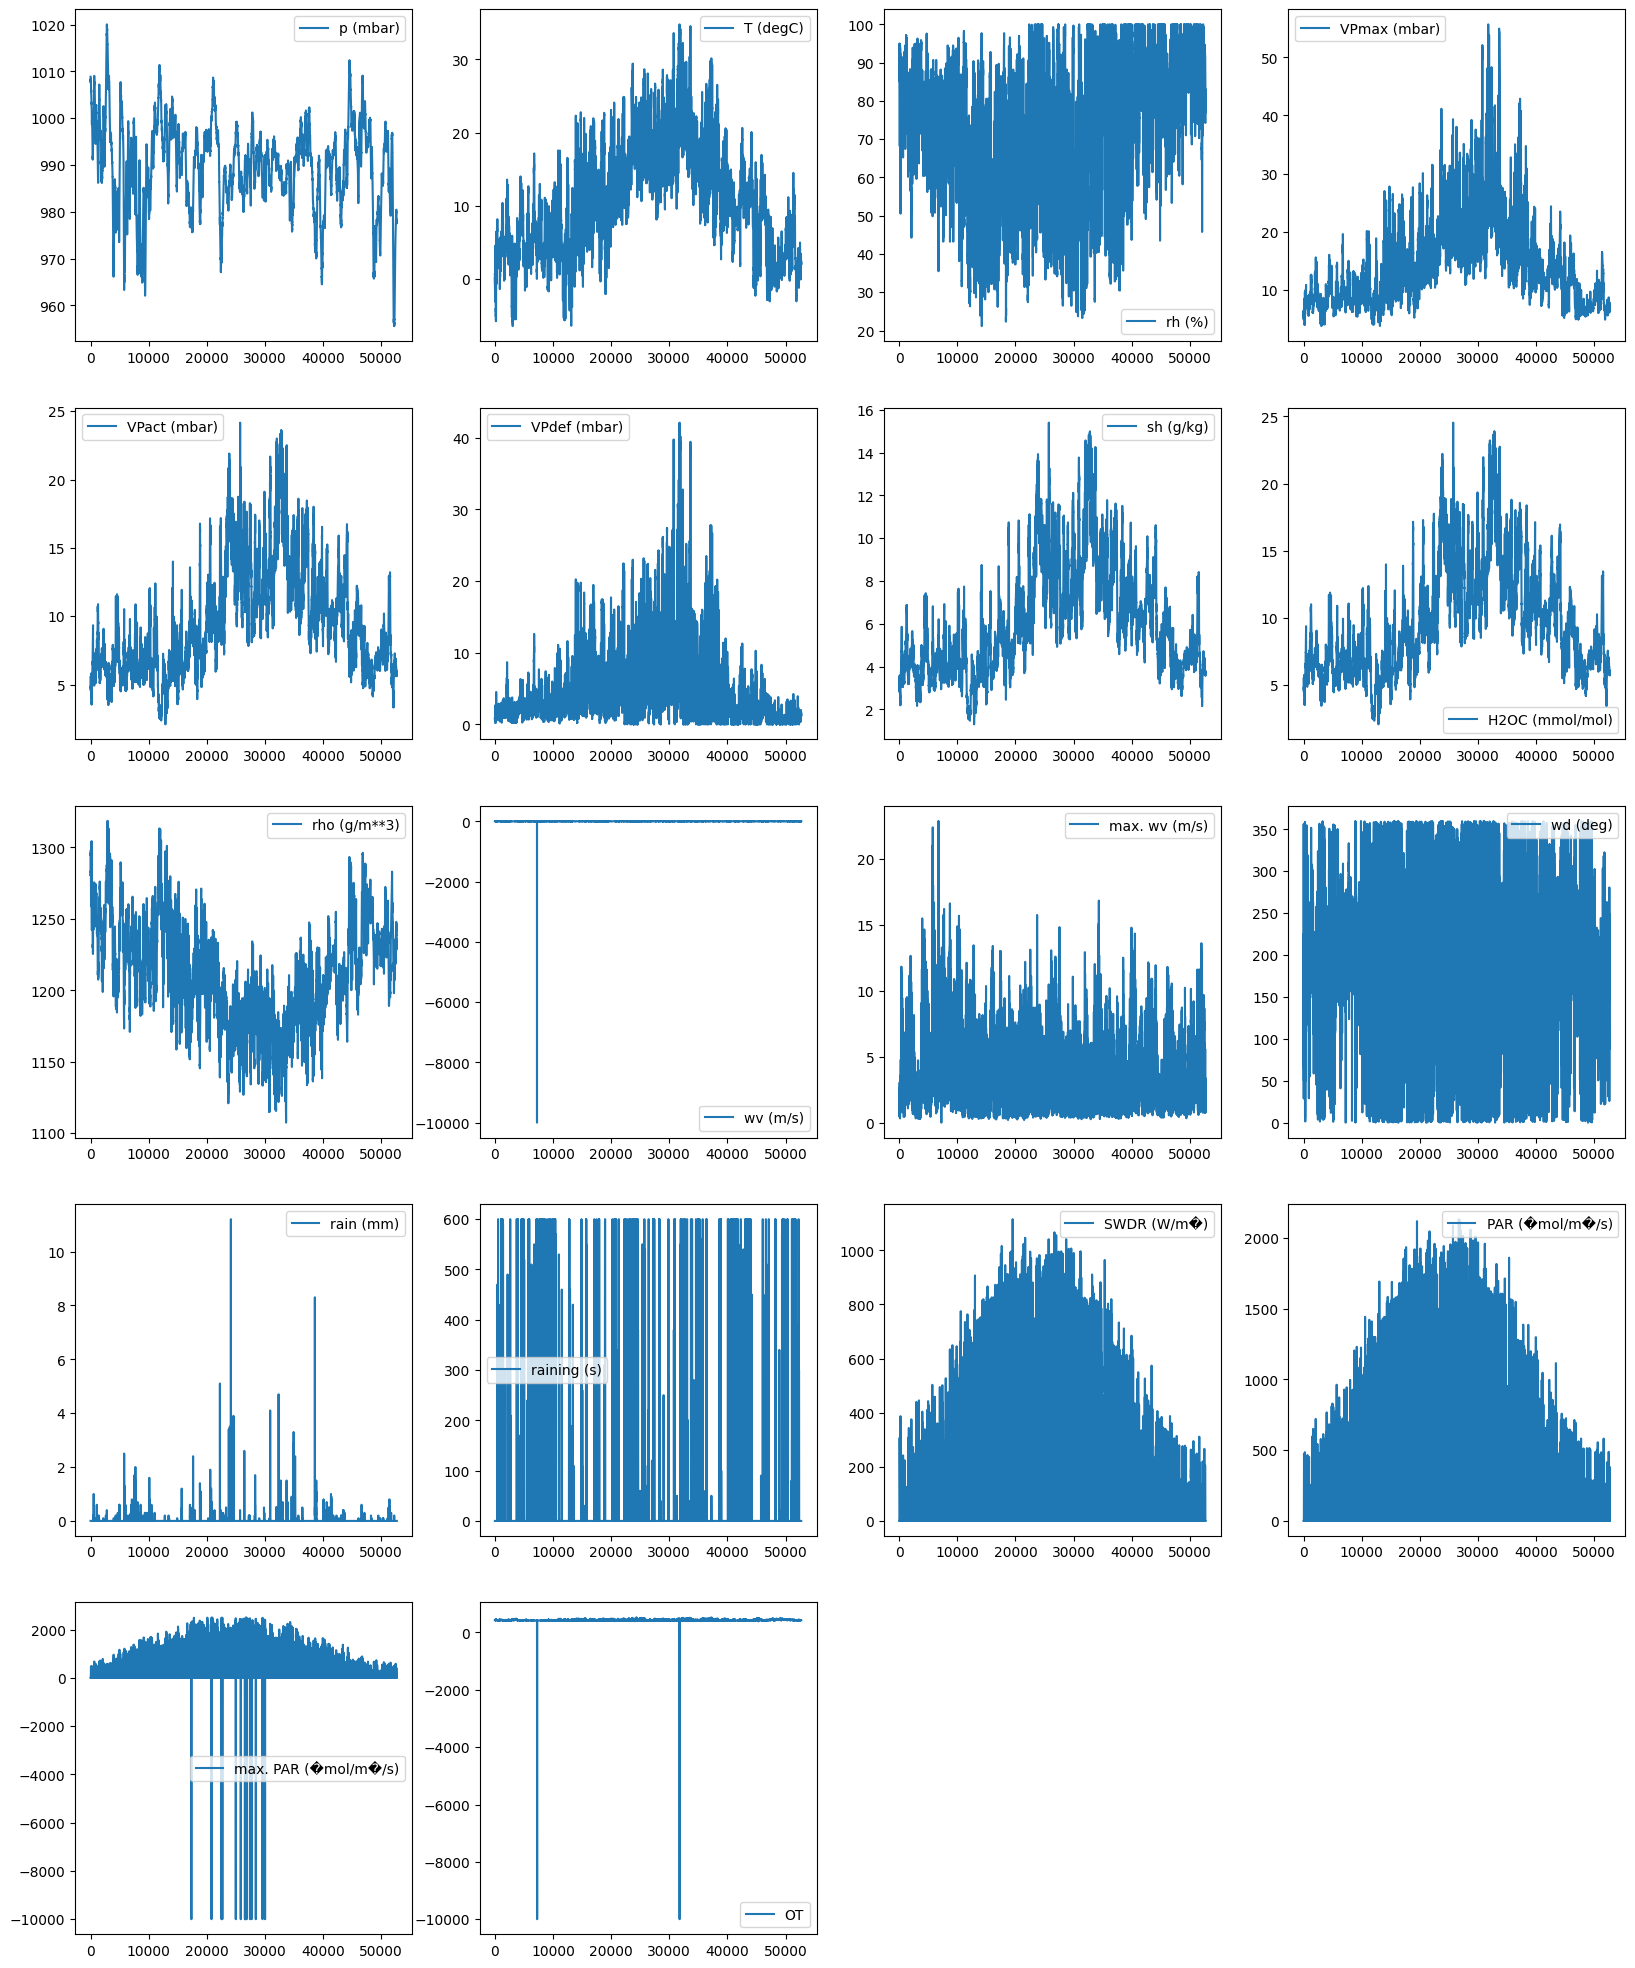

In [429]:
plots = dict(zip(list(weather.columns), list(weather.values.T)))
plot(plots)

In [409]:
context_size = 128
step_size = 10
batch_size = 64

class WindowedXDataset(Dataset):
    def __init__(self, x, y, window_size, step_size):
        self.x = x
        self.y = y
        self.window_size = window_size
        self.step_size = step_size

    def __len__(self):
        return (self.x.shape[0] - self.window_size - 1) // self.step_size + 1

    def __getitem__(self, idx):
        start_idx = idx * self.step_size
        end_idx = start_idx + self.window_size
        x_window = self.x[start_idx:end_idx]
        y = self.y[end_idx]
        return x_window, y

train_dataset = WindowedXDataset(X_train, Y_train, context_size, step_size)
test_dataset = WindowedXDataset(X_test, Y_test, context_size, step_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [436]:
def train(model, num_epochs=100, lr=1e-4):
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_loss_evolution = []
    for epoch in trange(num_epochs):
        epoch_loss = 0
        for X_batch, Y_batch in train_loader:
            output = model(X_batch)
            opt.zero_grad()
            loss = loss_fn(output, Y_batch)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        epoch_loss = epoch_loss / len(train_loader)
        train_loss_evolution.append(epoch_loss)
        clear_output()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        plot({"Train loss": train_loss_evolution})

def test(model):
    model.eval()
    predictions = []
    actual = []
    loss_fn = nn.MSELoss()
    with torch.no_grad():
        test_loss = 0.
        for inputs, targets in test_loader:
            output = model(inputs)
            loss = loss_fn(output, targets)
            test_loss += loss.item()
            predictions.extend(output.flatten().tolist())
            actual.extend(targets.flatten().tolist())
        print(f'Test Loss: {test_loss/len(test_loader):.4f}')
    
    plot({"Pred": np.array(predictions), "Actual": np.array(actual)}, same_plot=True)


In [430]:
class AttnHead(nn.Module):
    def __init__(self, num_heads, dk, dv, use_mask=True):
        super(AttnHead, self).__init__()
        self.num_heads = num_heads
        self.dk = dk
        self.dv = dv
        self.use_mask = use_mask
    
        self.Wq = nn.Parameter(torch.randn(num_heads, embedding_dim, dk))
        nn.init.kaiming_uniform_(self.Wq, a=math.sqrt(5))
        self.Wk = nn.Parameter(torch.randn(num_heads, embedding_dim, dk))
        nn.init.kaiming_uniform_(self.Wk, a=math.sqrt(5))
        self.Wv = nn.Parameter(torch.randn(num_heads, embedding_dim, dv))
        nn.init.kaiming_uniform_(self.Wv, a=math.sqrt(5))
        self.Wo = nn.Parameter(torch.randn(num_heads * dv, embedding_dim))
        nn.init.kaiming_uniform_(self.Wo, a=math.sqrt(5))
    def forward(self, x, returnKV=False ,KV=None):
        assert KV is None or (type(KV) is tuple and len(KV) == 2)
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        B, N, D = x.shape
        x = x.unsqueeze(1)
        q = x @ self.Wq.unsqueeze(0)
        if KV is None:
            k = x @ self.Wk.unsqueeze(0)
            v = x @ self.Wv.unsqueeze(0)
        else:
            k, v = KV
            
        qk =  q @ k.transpose(-2, -1) * (self.dk ** -0.5)

        if self.use_mask:
            mask = torch.tril_indices(qk.shape[-2], qk.shape[-1], -1)
            qk[:, :, mask[0], mask[1]] = float('-inf')
        softmax_qk = F.softmax(qk, dim=-1)
        qkv = softmax_qk @ v
        concat_qkv = qkv.permute(0, 2, 1, 3).reshape(B, N, self.num_heads * self.dv)
        out = concat_qkv @ self.Wo.unsqueeze(0)
        if returnKV:
            return out, k, v
        else:
            return out


In [437]:
class UnmaskedSingleSelfAttn(nn.Module):
    def __init__(self, dk=embedding_dim, dv=embedding_dim):
        super(UnmaskedSingleSelfAttn, self).__init__()
        self.attn = AttnHead(1, dk, dv, False)
        self.out = nn.Linear(embedding_dim * context_size, 1)
    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        batch_size, input_context_size, embedding_dim = x.shape
        assert input_context_size == context_size
        x = self.attn(x).reshape(batch_size, -1)
        return self.out(x)

Epoch 100/100, Loss: 7.7219


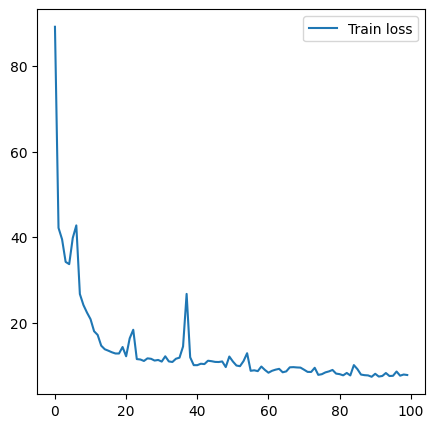

100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


In [440]:
model = UnmaskedSingleSelfAttn().to(device)
train(model)

Test Loss: 7.7758


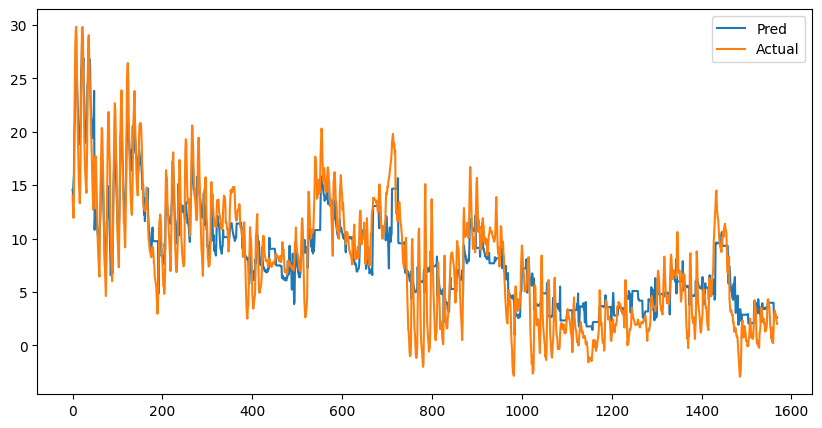

In [441]:
test(model)

In [434]:
class UnmaskedMultiSelfAttn(nn.Module):
    def __init__(self, num_heads, dk=embedding_dim, dv=embedding_dim):
        super(UnmaskedMultiSelfAttn, self).__init__()
        self.attn = AttnHead(num_heads, dk, dv, False)
        self.out = nn.Linear(embedding_dim * context_size, 1)
    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        batch_size, input_context_size, embedding_dim = x.shape
        assert input_context_size == context_size
        x = self.attn(x).reshape(batch_size, -1)
        return self.out(x)

Epoch 100/100, Loss: 6.0427


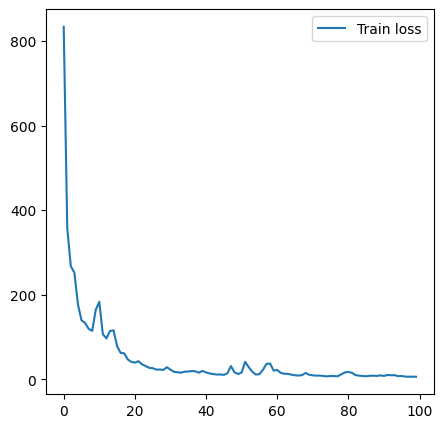

100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


In [442]:
num_heads = 10
model = UnmaskedMultiSelfAttn(num_heads).to(device)
train(model)

Test Loss: 5.7777


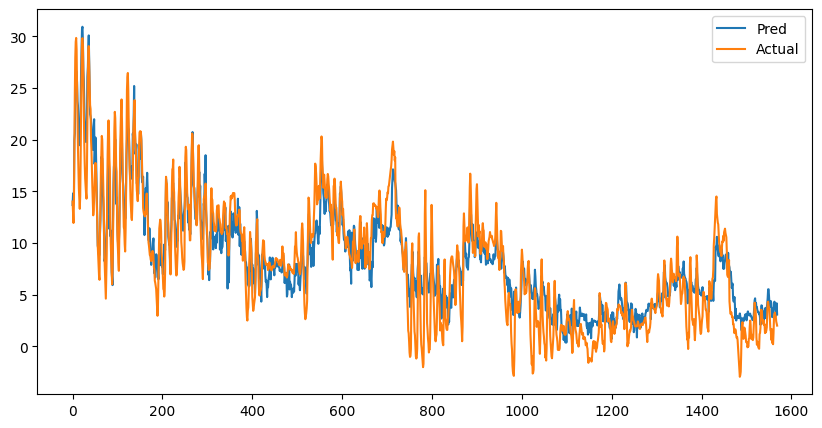

In [443]:
test(model)

In [444]:
class EncoderLayer(nn.Module):
    def __init__(self, num_heads, dk=embedding_dim, dv=embedding_dim):
        super(EncoderLayer, self).__init__()
        self.attn = AttnHead(num_heads, dk, dv, False)
        self.attn_norm = nn.LayerNorm(embedding_dim)
        self.conv_norm = nn.LayerNorm(embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, embedding_dim, kernel_size=3, padding=1)
    def forward(self, x, outputKV=False):
        x = self.attn_norm(x + self.attn(x))
        x = self.conv_norm(x + F.relu(self.conv(x.permute(0, 2, 1))).permute(0, 2, 1))
        if outputKV:
            _, k, v = self.attn(x, returnKV=True)
            return k, v
        else:
            return x


In [445]:
class Encoder(nn.Module):
    def __init__(self, num_layers, heads_per_layer, dk=embedding_dim, dv=embedding_dim, output_KV=False):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.attn_layers.append(EncoderLayer(heads_per_layer, dk, dv))
        self.output_KV = output_KV
        if not output_KV:
            self.out = nn.Linear(embedding_dim * context_size, 1)
    def forward(self, x):
        k, v  = None, None
        for i, layer in enumerate(self.attn_layers):
            if i == len(self.attn_layers) - 1 and self.output_KV:
                k, v = layer(x, outputKV=True)
            else:
                x = layer(x)
        if not self.output_KV:
            x = x.reshape(x.shape[0], -1)
            return self.out(x)
        else:
            return k, v

Epoch 100/100, Loss: 2.3995


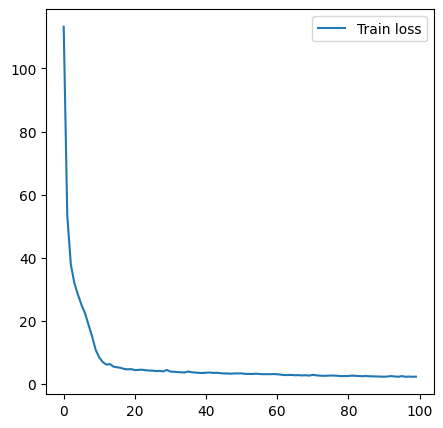

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


In [446]:
num_heads = 5
num_layers = 3
model = Encoder(num_layers, num_heads).to(device)
train(model)

Test Loss: 3.5130


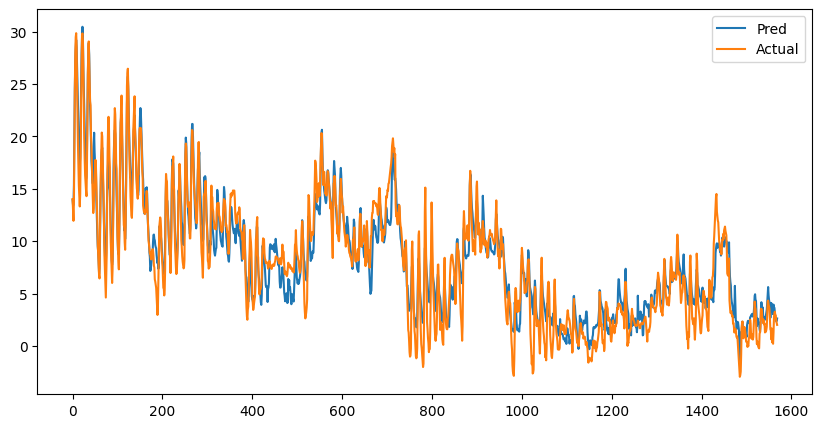

In [447]:
test(model)


In [448]:
class DecoderLayer(nn.Module):
    def __init__(self, num_heads, dk=embedding_dim, dv=embedding_dim):
        super(DecoderLayer, self).__init__()
        self.masked_attn = AttnHead(num_heads, dk, dv, True)
        self.unmasked_attn = AttnHead(num_heads, dk, dv, False)
        self.masked_attn_norm = nn.LayerNorm(embedding_dim)
        self.unmasked_attn_norm = nn.LayerNorm(embedding_dim)
        self.conv_norm = nn.LayerNorm(embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, embedding_dim, kernel_size=3, padding=1)
    def forward(self, x, KV=None):
        x = self.masked_attn_norm(x + self.masked_attn(x))
        x = self.unmasked_attn_norm(x + self.unmasked_attn(x, KV=KV))
        x = self.conv_norm(x + F.relu(self.conv(x.permute(0, 2, 1))).permute(0, 2, 1))
        return x

In [449]:
class Decoder(nn.Module):
    def __init__(self, num_layers, heads_per_layer, dk=embedding_dim, dv=embedding_dim):
        super(Decoder, self).__init__()
        self.attn_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.attn_layers.append(DecoderLayer(heads_per_layer, dk, dv))
        self.out = nn.Linear(embedding_dim * context_size, 1)
    def forward(self, x, KV=None):
        for layer in self.attn_layers:
            x = layer(x, KV)
        x = x.reshape(x.shape[0], -1)
        return self.out(x)

Epoch 100/100, Loss: 0.7354


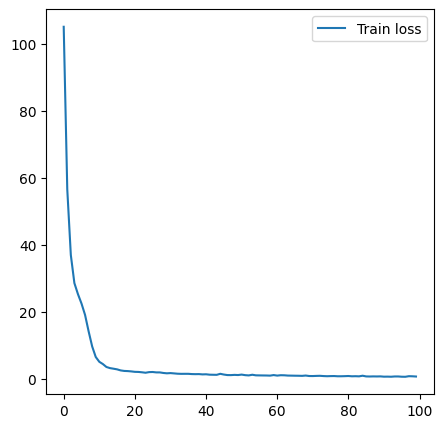

100%|██████████| 100/100 [05:33<00:00,  3.34s/it]


In [450]:
num_heads = 5
num_layers = 3
model = Decoder(num_layers, num_heads).to(device)
train(model)

Test Loss: 0.7734


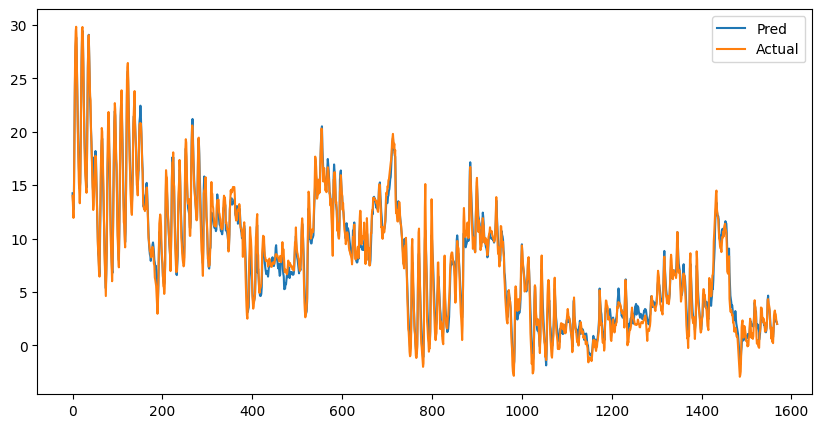

In [451]:
test(model)

In [452]:
class Transformer(nn.Module):
    def __init__(self, num_layers, heads_per_layer, dk=embedding_dim, dv=embedding_dim):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, heads_per_layer, output_KV=True)
        self.decoder = Decoder(num_layers, heads_per_layer)
    def forward(self, x):
        KV = self.encoder(x)
        x = self.decoder(x, KV)
        return x

Epoch 100/100, Loss: 0.5175


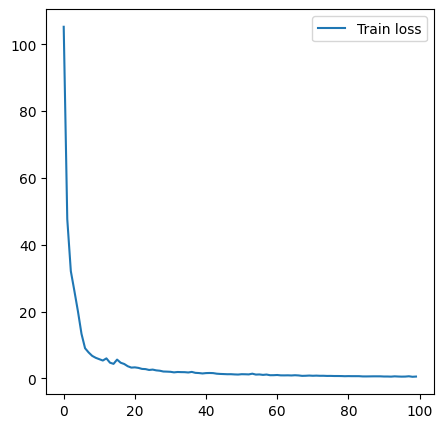

100%|██████████| 100/100 [07:18<00:00,  4.38s/it]


In [453]:
num_heads = 5
num_layers = 3
model = Transformer(num_layers, num_heads).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
train(model)

Test Loss: 0.6278


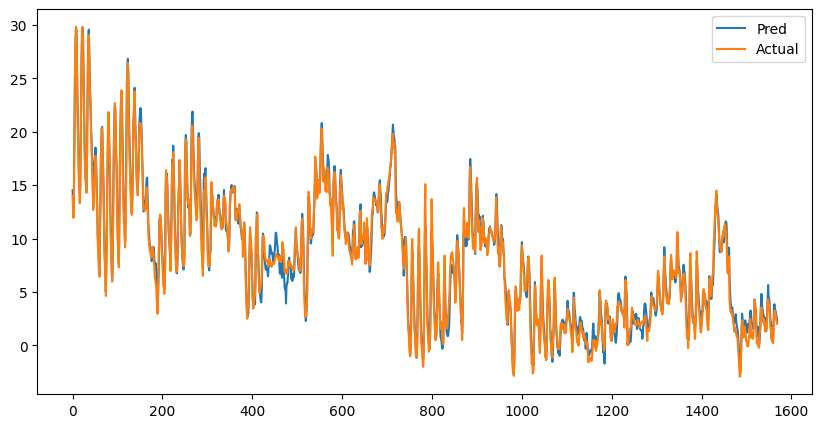

In [454]:
test(model)